# Testing triggers in metadata / audio file

Exploring the audio file triggers that are sent to the MEG on the audio channel to verify if they are well-encoded in the first place, compared to the event defined in the metadata

In [112]:
import numpy as np 

from scipy.io import wavfile

import matplotlib.pyplot as plt


# Opening the wav file for the first chapter
wav_file = '/media/co/T7/workspace-LPP/data/MEG/LPP/PallierListen2023/download/sourcedata/stimuli/audio/ch1-3.wav'

fs, data = wavfile.read(wav_file)

# Getting the channel for the triggers encoded in the 2nd part of the wav
data = data[:,1]
data = np.round(data / 30000)

In [113]:
indices = np.where(data == 1)[0]
# Calculate the differences between consecutive indices
differences = np.diff(data)

plus = np.where(differences == 1)[0]
minus = np.where(differences == -1)[0]

plus, minus

diffs = []
for p, m in zip(plus, minus):
    # Take the min of the substraction to see if some triggers are under 300 / 44100 s long
    diffs.append(m-p)
    

In [114]:
np.unique(diffs)

array([300])

In [115]:
# All good

In [117]:
diff = np.diff(data)

In [118]:
audio_triggers = np.where(diff == 1)[0]

# Get the amount of triggers in the metadata file

file = "/home/co/sub-1_ses-01_task-listen_run-01_events.tsv"

import pandas as pd

df = pd.read_csv(file, sep='\t')

meta_triggers = df.onset

print("Number of triggers in the audio file : ", len(audio_triggers))
print("Number of triggers in the meta file : ", len(meta_triggers))


print("Length of the audio file : ", (audio_triggers[-1] - audio_triggers[0] )/ fs)
print("Length of the meta file : ", (meta_triggers.iloc[-1] - meta_triggers.iloc[0]))
      
#Number of triggers in the audio file :  1614
#Number of triggers in the meta file :  1632
#Length of the audio file :  607.15
#Length of the meta file :  607.1500000000001

# We have the same length (end - start), which is a good thing: there is no problem at this point

# We have a small difference (18 words that might have been split in the metadata file, and be only one
# trigger in the wav file...

Number of triggers in the audio file :  1614
Number of triggers in the meta file :  1632
Length of the audio file :  607.15
Length of the meta file :  607.1500000000001


# From the MEG triggers now

Let's try to investigate what's the difference with the triggers saved in the raw file now, that seem to be quite differents

In [5]:
# Neuro
import mne
import mne_bids

# ML/Data
import numpy as np
import pandas as pd

# Tools
from pathlib import Path
import os
import matplotlib.pyplot as plt

from utils import get_path
from utils import (
    match_list,
    add_syntax,
    mne_events,
    decoding_from_criterion,
    get_code_path,
    get_path,
)


modality = "auditory"
subject = '2'
run_id = "01"


In [155]:
path = get_path(modality)
task_map = {"auditory": "listen", "visual": "read", "fmri": "listen"}
task = task_map[modality]
print(f"\n Epoching for run {run_id}, subject: {subject}\n")
bids_path = mne_bids.BIDSPath(
    subject=subject,
    session="01",
    task=task,
    datatype="meg",
    root=path,
    run=run_id,
)

raw = mne_bids.read_raw_bids(bids_path)
# triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=1)
triggers = mne.find_events(raw, stim_channel="STI101", shortest_event=10)

raw.del_proj()  # To fix proj issues
raw.pick_types(meg=True, stim=False)
raw.load_data()

# Generate event_file path
event_file = path / f"sub-{bids_path.subject}"
event_file = event_file / f"ses-{bids_path.session}"
event_file = event_file / "meg"
event_file = str(event_file / f"sub-{bids_path.subject}")
event_file += f"_ses-{bids_path.session}"
event_file += f"_task-{bids_path.task}"
event_file += f"_run-{bids_path.run}_events.tsv"
assert Path(event_file).exists()

meta = pd.read_csv(event_file, sep="\t")

meta['start'] = meta.onset


 Epoching for run 01, subject: 2

Opening raw data file /home/co/data/LPP_MEG_auditory/sub-2/ses-01/meg/sub-2_ses-01_task-listen_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 25000 ... 659999 =     25.000 ...   659.999 secs
Ready.
Reading events from /home/co/data/LPP_MEG_auditor

<ipython-input-155-ca59e5dcf264>:14: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
<ipython-input-155-ca59e5dcf264>:14: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1647 events found
Event IDs: [  1 128]
Reading 0 ... 634999  =      0.000 ...   634.999 secs...


In [156]:
words = meta

events_df = meta
# Triggers from the MEG: :, 2 is the trigger value: 1 is a word, 128 is the start / end
word_triggers = triggers[triggers[:, 2] > 1]

## Conclusion

We find that the length of the trigger from MEG is at least one second longer than the meta file / audio file...
They are calculated by simply takign the last word trigger, 
There must be something that makes the triggers happen slower.. or 

In [62]:
print("Number of triggers in the audio file : ", len(audio_triggers))
print("Number of triggers in the meta file : ", len(meta_triggers))
print("Number of triggers in the MEG triggers : ", word_triggers.shape[0])

print('\n')

print("Duration of the audio file (s): ", (audio_triggers[-1] - audio_triggers[0] )/ fs)
print("Duration of the meta file (s): ", (meta_triggers.iloc[-1] - meta_triggers.iloc[0]))
print("Duration of the trigger from MEG (first word to last word) : ", (word_triggers[-1][0] - word_triggers[0][0]) / raw.info['sfreq'])

print('\n')

print("Time from the start of the audio to the first word IN THE TRIGGERS: ", (triggers[1,0] - triggers[0,0]) / raw.info['sfreq'])
print("Time from the start of the audio to the first word IN THE METADATA: ", meta_triggers[0] )



Number of triggers in the audio file :  1614
Number of triggers in the meta file :  1632
Number of triggers in the MEG triggers :  1645


Length of the audio file :  607.15
Length of the meta file :  607.1500000000001
Length of the trigger from MEG (first word to last word) :  608.175


Time from the start of the audio to the first word IN THE TRIGGERS:  3.272
Time from the start of the audio to the first word IN THE METADATA:  3.05


# define events from first meg channel trigger + text_grid.starts
make mne Epochs from from these events, (and not from trigger channel)
1. show matrix x=time from word-onset, y=single trial misc channel


In [53]:
first_meg_trigger = triggers[0][0]
first_meg_trigger

42046

In [11]:
def mne_events(meta):
    events = np.ones((len(meta), 3), dtype=int)
    events[:, 0] = first_meg_trigger + (meta.start*raw.info['sfreq'])
    return dict(events=events, metadata=meta.reset_index())

In [12]:
raw.filter(.5, 20., n_jobs=-1)

epochs = mne.Epochs(raw, **mne_events(meta), decim=10, tmin=-.2, tmax=.8)
epochs 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  60 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 228 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 306 out of 306 | elapsed:    5.9s finished


Adding metadata with 6 columns
1632 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated


Number of events,1632
Events,1: 1632
Time range,-0.200 – 0.800 sec
Baseline,-0.200 – 0.000 sec


In [13]:
epochs.info

<Info | 24 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: []
 ch_names: MEG0113, MEG0112, MEG0111, MEG0122, MEG0123, MEG0121, MEG0132, ...
 chs: 204 Gradiometers, 102 Magnetometers
 custom_ref_applied: False
 description: Anonymized using a time shift to preserve age at acquisition
 dev_head_t: MEG device -> head transform
 dig: 59 items (3 Cardinal, 4 HPI, 52 Extra)
 events: 1 item (list)
 experimenter: mne_anonymize
 file_id: 4 items (dict)
 highpass: 0.5 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 hpi_subsystem: 3 items (dict)
 line_freq: 50.0
 lowpass: 20.0 Hz
 maxshield: True
 meas_date: 2022-09-22 12:44:54 UTC
 meas_id: 4 items (dict)
 nchan: 306
 proc_history: 1 item (list)
 proj_id: 1 item (ndarray)
 proj_name: mne_anonymize
 projs: []
 sfreq: 100.0 Hz
 subject_info: 9 items (dict)
>

Plotting the information of for each trigger: the metadata time expected vs the time found in the triggers.

Text(0.5, 1.0, 'Comparing the time from the supposed trigger sample to sample')

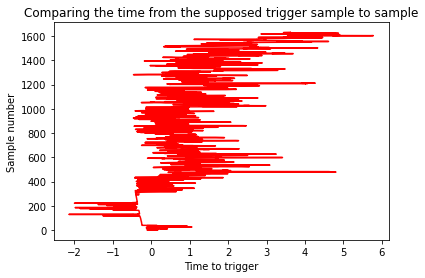

In [79]:
import matplotlib.pyplot as plt

x_to_plot = []
y_to_plot = []

for i in range(1,epochs.events.shape[0]):
    epoch = epochs[i]
    theoritical_metadata_time = epoch.events[0][0]
    trigger_time = triggers[i][0]
    x_to_plot.append((theoritical_metadata_time - trigger_time) / raw.info['sfreq'])
    y_to_plot.append(i)

plt.plot(x_to_plot[:], y_to_plot[:], 'r')
#plt.plot(trigger_time, i, color='b')
plt.xlabel("Time to trigger")
plt.ylabel("Sample number")
plt.title("Comparing the time from the supposed trigger sample to sample")

Might want to do it by matching all the samples, as we have a diff in the number of samples... 

N_triggers_MEG > N_triggers_metadata > N_triggers_audio....

## Using the match list

Let's investigate what kind of word is removed when using the match list technique???

In [157]:
events_df["word"] = meta["trial_type"].apply(
            lambda x: eval(x)["word"] if type(eval(x)) == dict else np.nan)

decimals = 2
triggers_delta = np.round(np.diff(word_triggers[:, 0] / raw.info["sfreq"]), decimals=decimals)  # type: ignore
events_delta = np.round(np.diff(words.start.values), decimals=decimals)  # type: ignore
i, j = match_list(triggers_delta, events_delta)

assert len(i) / len(words) > 0.7, (
    error_msg_prefix
    + f"only {len(i)/len(words)} of the words were found in the triggers"
)
print(f"Found {len(i)/len(words)} of the words in the triggers")

true_indices = words.iloc[j].index
# Le problème que l'on a en audio et pas en lecture: quand on set les true_indices
# et qu'on fait le loc, on réécrit pas mal de start, mais on en garde des anciens (qui n'ont pas survécu
# au match list) qui gardent leur valeur, donc la ligne suivante ne leur est pas appliquée, et ils
# deviennet de fausses epochs.

# Solution: on drop les tuples qui ne font pas partie des true indices ? ou on met leur start à Nan ?

# Set the start for true indices, and remove the one that are not true indices

events_df = events_df.loc[true_indices].copy()

events_df.loc[true_indices, "start"] = (
    word_triggers[i, 0] / raw.info["sfreq"]
)

Found 0.9258578431372549 of the words in the triggers


In [158]:
events_df.shape

(1511, 6)

In [142]:
events_df = events_df.sort_values(by="start").reset_index(drop=True)

In [145]:
events_df.shape

(1632, 6)

In [144]:
events_df.loc[true_indices, "start"] = (
    word_triggers[i, 0] / raw.info["sfreq"]
)

In [168]:
events_df.start[-2:-1] + events_df.duration[-2:-1] - events_df.start[0] 

1629    608.015
dtype: float64

In [164]:
events_df.word

0       lorsque
1             j
2         avais
3           six
4           ans
         ...   
1626         ne
1627       peut
1628        pas
1629      aller
1630       bien
Name: word, Length: 1511, dtype: object

In [177]:
word_left_after_match = np.array(events_df.word)

all_words = words.word.values

missing_words = np.setdiff1d(all_words, word_left_after_match)

# Print the missing words
print(missing_words)

[' ' 'abandonné' 'arizona' 'as' 'attaches' 'au' 'aux' 'bouger' 'connaître'
 'conseillé' 'cornes' 'cravates' 'dangereux' 'donné' 'donnée' 'du'
 'encombrant' 'enfonça' 'herbe' 'idée' 'océan' 'oeil' 'ose' 'perdra'
 'prenne' 'répondre' 'répondu' 'sérieuse' 'venait' 'étoiles']


In [187]:
def find_missing_words2(array1, array2):
    dict1 = {}
    dict2 = {}

    for word in array1:
        if word in dict1:
            dict1[word] += 1
        else:
            dict1[word] = 1

    for word in array2:
        if word in dict2:
            dict2[word] += 1
        else:
            dict2[word] = 1

    missing_words = []
    total_missing = 0
    for word in dict1:
        if word not in dict2:
            missing_words.append((word, dict1[word]))
            total_missing += dict1[word]
        elif dict1[word] > dict2[word]:
            missing_words.append((word, dict1[word] - dict2[word]))
            total_missing += dict1[word] - dict2[word]

    return missing_words, total_missing


In [188]:
missing, total= find_missing_words2(all_words, word_left_after_match)

In [189]:
total
# It matches perfectly with the number of words missing

121

Next step: understanding which starts are linked with the words so I could see if it's regular / linked to a particular type of word / etc